<a href="https://colab.research.google.com/github/ru2zi/Deep-Learning-Approaches-to-RUL-Prediction-of-Lithium-ion-Batteries/blob/main/RUL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/RUL/5. 배터리 RUL 예측/Battery_RUL_data.csv')

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df.columns

In [ ]:
import plotly.express as px
from plotly.subplots import make_subplots

# Selecting only float64 data columns
float_cols = df.select_dtypes(include=['float64']).columns

# Splitting columns into groups of 3
col_sets = [float_cols[n:n+3] for n in range(0, len(float_cols), 3)]

for cols in col_sets:
    # Change rows and cols to make it horizontal
    fig = make_subplots(rows=len(cols), cols=1, subplot_titles=cols)
    for idx, col in enumerate(cols, start=1):
        hist_fig = px.histogram(df, x=col)
        for trace in hist_fig.data:
            fig.add_trace(trace, row=idx, col=1)  # Change the row and col
    fig.show()


In [ ]:
import plotly.express as px

# Selecting only float64 data columns
float_cols = df.select_dtypes(include=['float64']).columns

for col in float_cols:
    fig = px.histogram(df, x=col, histnorm='percent', cumulative=True)
    fig.update_layout(title=f'Cumulative Distribution Function for {col}')
    fig.show()


## 이상치
### Z-score:
- 정규분포 가정: Z-score는 데이터가 근사적으로 정규분포를 따르는 경우 더 효과적입니다. Z-score는 데이터 포인트의 값이 평균에서 얼마나 떨어져 있는지를 나타내며, 표준편차 단위로 측정됩니다. <br>
- 표준화된 척도: Z-score는 데이터의 절대적인 값을 사용하지 않기 때문에 다양한 데이터 집합 간에 이상치를 비교하거나 식별하는 데 유용합니다.<br>
- 정확한 위치 식별: Z-score는 각 데이터 포인트에 대해 개별적으로 계산되므로 이상치의 정확한 위치를 식별하는 데 도움이 됩니다.<br>

### IQR:
- 비정규분포 데이터: IQR은 데이터가 정규분포를 따르지 않을 때 또는 분포에 대해 알 수 없을 때 유용합니다.<br>
- 로버스트성: IQR은 중앙값과 사분위수를 기반으로 하므로, 극단값에 덜 민감하며, 이상치의 영향을 적게 받습니다.

In [ ]:
# List of specified columns for outlier removal
specified_cols = ['Discharge Time (s)', 'Decrement 3.6-3.4V (s)', 'Time at 4.15V (s)', 'Time constant current (s)', 'Charging time (s)']


In [ ]:
# Checking normality using Shapiro-Wilk test
normality_results = {}

for col in specified_cols:
    stat, p = shapiro(df[col])
    normality_results[col] = p > 0.05  # True if normal, False otherwise

normality_results


In [ ]:
#평균과 표준편차를 사용하여 z-score를 계산하고, z-score가 일정 임계값을 초과하는 값을 이상치로 간주

# Define a function to detect outliers based on Z-score
def zscore_outliers(data, column, threshold=3):
    z_scores = np.abs(zscore(data[column]))
    return np.where(z_scores > threshold)[0]

# Applying Z-score method
zscore_outliers_dict = {}
for col in specified_cols:
    zscore_outliers_dict[col] = zscore_outliers(df, col)

# Combine outliers from both methods (Grubbs' test and Z-score method)
combined_outliers_z = set()
for col in specified_cols:
    combined_outliers_z.update(outliers[col])
    combined_outliers_z.update(zscore_outliers_dict[col])

# Remove the outliers
df_cleaned_z = df.drop(index=combined_outliers_z).reset_index(drop=True)

df_cleaned_z


In [ ]:
import plotly.express as px
from plotly.subplots import make_subplots

# Selecting only float64 data columns
float_cols = df_cleaned_z.select_dtypes(include=['float64']).columns

# Splitting columns into groups of 3
col_sets = [float_cols[n:n+3] for n in range(0, len(float_cols), 3)]

for cols in col_sets:
    # Change rows and cols to make it horizontal
    fig = make_subplots(rows=len(cols), cols=1, subplot_titles=cols)
    for idx, col in enumerate(cols, start=1):
        hist_fig = px.histogram(df_cleaned_z, x=col)
        for trace in hist_fig.data:
            fig.add_trace(trace, row=idx, col=1)  # Change the row and col
    fig.show()


In [ ]:
# Define a function to remove outliers based on IQR
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out the outliers
    filtered = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

    return filtered

# Apply the outlier removal for each specified column
for col in specified_cols:
    df_IQR = remove_outliers_iqr(df, col)

df_IQR.reset_index(drop=True, inplace=True)  # Resetting the index after removing rows
df_IQR


## 전처리

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
X = df_IQR.drop('RUL', axis=1)
y = df_IQR['RUL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)  #train꺼로 transform한걸로 fit 중요!!!!
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 모델

[EMD-CNN-LSTM](http://210.101.116.16/xml/html/%EC%A0%84%EB%A0%A5%EC%A0%84%EC%9E%90%ED%95%99%ED%9A%8C/%EA%B5%AD%EB%AC%B8/27_1/7.%EC%9E%84%EC%A0%9C%EC%98%81/%EC%9E%84%EC%A0%9C%EC%98%81.html)

EMD: 시계열 데이터를 IMF로 분해합니다. <br>
CNN: 각 IMF를 CNN을 통해 처리하고 특징을 추출합니다.<br>
LSTM: CNN에서 추출된 특징을 LSTM에 공급하여 시계열 예측을 수행합니다.

In [ ]:
pip install EMD-signal

In [ ]:
from PyEMD import EMD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 1. EMD Decomposition (for demonstration, we'll just decompose one of the columns)
selected_column = X_train_scaled[:, 0]  # Selecting the first column for demonstration
emd = EMD()
IMFs = emd(selected_column)

# Reshaping IMFs for CNN
IMFs_reshaped = IMFs.T.reshape(IMFs.shape[1], IMFs.shape[0], 1)

# 2. Create the EMD-CNN-LSTM model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(IMFs_reshaped.shape[1], IMFs_reshaped.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Splitting IMFs for training and validation
train_size = int(len(IMFs_reshaped) * 0.8)
train_IMFs, test_IMFs = IMFs_reshaped[:train_size], IMFs_reshaped[train_size:]
train_y, test_y = y_train[:train_size], y_train[train_size:]

# Setting up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Train the model with callbacks
history = model.fit(train_IMFs, train_y, epochs=100, batch_size=16, validation_data=(test_IMFs, test_y),
                    verbose=2, callbacks=[early_stopping, model_checkpoint])

# Visualizing training and validation loss
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
epochs = range(1, len(loss_values) + 1)

# Plotting the loss values
fig = go.Figure()
fig.add_trace(go.Scatter(x=epochs, y=loss_values, mode='lines', name='Training Loss'))
fig.add_trace(go.Scatter(x=epochs, y=val_loss_values, mode='lines', name='Validation Loss'))
fig.update_layout(title='Training and Validation Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()


## 성능 확인

In [ ]:
import plotly.graph_objects as go

# Visualizing the predicted vs actual RUL values
fig = go.Figure()

# Actual RUL values
fig.add_trace(go.Scatter(y=test_y, mode='lines', name='Actual RUL'))

# Predicted RUL values
fig.add_trace(go.Scatter(y=y_pred.flatten(), mode='lines', name='Predicted RUL'))

fig.update_layout(title='Actual vs Predicted RUL', xaxis_title='Index', yaxis_title='RUL Value')
fig.show()

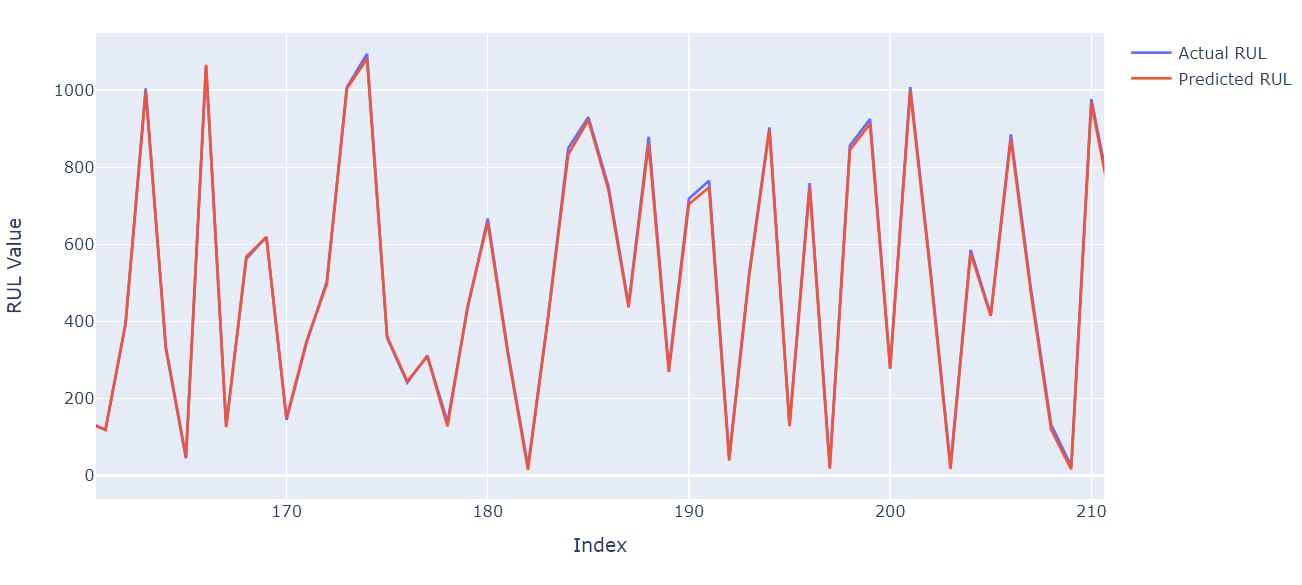

In [ ]:
# Calculating the Mean Absolute Percentage Error (MAPE)
mape = 100 * np.mean(np.abs((test_y - y_pred.flatten()) / test_y))
mape

In [ ]:
# 5.238106174086058